# Training an ML algorithm to predict listeners backchannel behaviours (head nods)

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import neighbors
from sklearn import model_selection
from sklearn import metrics

%matplotlib inline

#### ML Settings

In [2]:
RESAMPLING_PERIOD = 100  # millis
WINDOW_SIZE = 30

#### Plotting settings

In [3]:
FIGSIZE = (10, 6)

## Inspect the data

Looking at `interaction002` as an arbitrary example.

In [4]:
store = pd.HDFStore('data.hdf')

In [5]:
print(store.keys())
print(f'total: {len(store)}')

['/interaction002', '/interaction006', '/interaction015', '/interaction027', '/interaction038', '/interaction039', '/interaction044', '/interaction047', '/interaction050', '/interaction053', '/interaction060', '/interaction069', '/interaction083', '/interaction101', '/interaction102', '/interaction106', '/interaction110', '/interaction111', '/interaction112', '/interaction114', '/interaction115', '/interaction116', '/interaction130', '/interaction131', '/interaction132', '/interaction134', '/interaction136', '/interaction137', '/interaction138', '/interaction139', '/interaction142', '/interaction143', '/interaction144', '/interaction145', '/interaction146', '/interaction147', '/interaction148', '/interaction149', '/interaction150', '/interaction151', '/interaction154', '/interaction155', '/interaction159', '/interaction161', '/interaction162', '/interaction163', '/interaction164', '/interaction165']
total: 48


In [6]:
store.interaction002.head(10)

,speaker_behaviour,speaker_eye,listener_nod
time,,,
00:00:00,Start,False,False
00:00:02.800000,Start,True,False
00:00:03.480000,Start,False,False
00:00:03.875000,SpeechNormal,False,False
00:00:04.625000,PunctualPositiveSpeech,False,False
00:00:04.625000,SpeechSilent,False,False
00:00:04.906000,SpeechNormal,False,False
00:00:05.578000,PunctualPositiveSpeech,False,False
00:00:05.578000,SpeechSilent,False,False


Not all interactions contain all of the speaker behaviour labels. Running once through all of them to collect all of the behaviours for building hot-ones columns later.

In [7]:
def find_all_speaker_behaviours(store):
    speaker_behaviours = set()
    for key in store:
        df = store[key]
        speaker_behaviours.update(df.speaker_behaviour)

    speaker_behaviours.remove('Start')
    return sorted(speaker_behaviours)
        
        
speaker_behaviours = find_all_speaker_behaviours(store)
print(speaker_behaviours)

['PunctualAskQuestion', 'PunctualBackchannel', 'PunctualNegativeSpeech', 'PunctualPositiveSpeech', 'SpeechLoud', 'SpeechLoud2', 'SpeechLoud3', 'SpeechNormal', 'SpeechSilent']


In [8]:
def prepare_for_training(df, hot_ones_columns):
    """
    - Resample the data.
    - Drop rows that are labeled as "Start".
    - Convert the "speaker_behaviour" column to hot-ones.
    - Add missing hot-ones columns (not all labels were used in each interaction).
    """
    # L stands for millis
    df = df.resample(f'{RESAMPLING_PERIOD}L').first().ffill()

    df = df[df.speaker_behaviour != 'Start']

    hot_ones = pd.get_dummies(df.speaker_behaviour)
    hot_ones = [_hot_ones_column(hot_ones, key) for key in hot_ones_columns]
    return pd.concat(hot_ones + [df.speaker_eye, df.listener_nod], axis=1).astype(bool)


def _hot_ones_column(hot_ones, column):
    if column in hot_ones.columns:
        return hot_ones[column]
    return pd.DataFrame({column: [False] * len(hot_ones)}, index=hot_ones.index)

In [9]:
def plot_data(df, figsize=FIGSIZE):
    """
    Plot the (already prepared for training) interaction for investigation.
    """
    spreaded = df - np.arange(len(df.columns)) * 2
    spreaded.plot(figsize=figsize)

    # Put a legend to the right of the current axis
    plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Hide Y axis labels
    plt.yticks([])

/interaction039
/interaction106
/interaction115


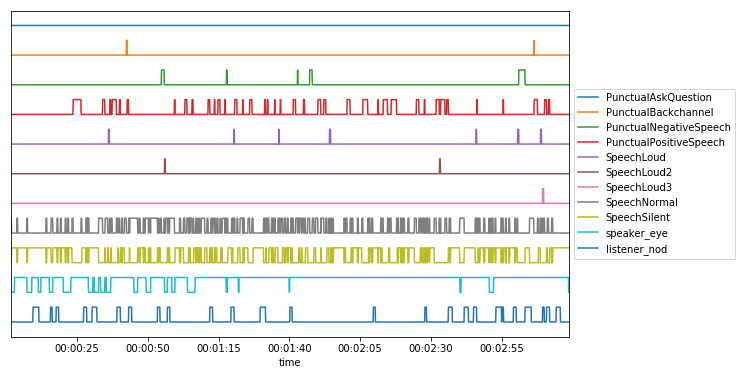

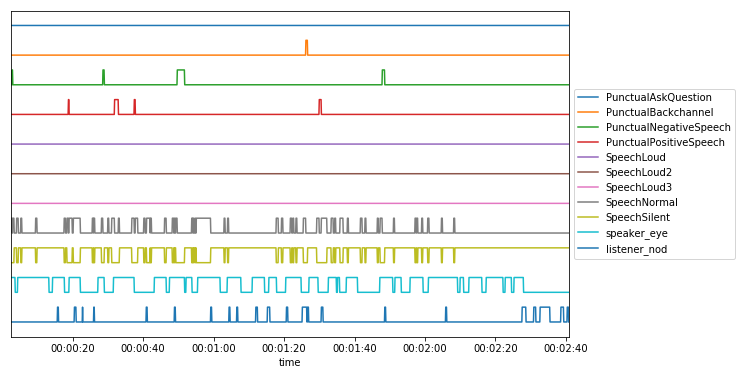

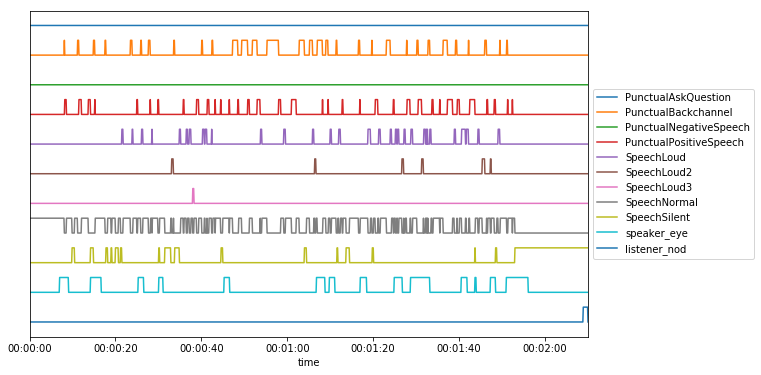

In [10]:
for key in random.sample(store.keys(), 3):
    print(key)
    plot_data(prepare_for_training(store[key], speaker_behaviours))

In [11]:
def to_samples(df, n=WINDOW_SIZE):
    """
    Break an interaction into many samples in the form of `np.ndarray`.
    Each sample contains features from points in time up until the
    corrent one (including), and the `listener_nod` of the current time.
    """
    values = df.values
    num_of_samples = len(values) - n + 1
    X = np.array([_take_X(values, i, n) for i in range(num_of_samples)])
    Y = values[n - 1:, -1][:, np.newaxis]
    return np.hstack([X, Y])


def _take_X(values, i, n):
    return values[i:i + n, :-1].flatten()
    

def test_to_samples():
    example = pd.DataFrame([
        [1, 100],
        [2, 200],
        [3, 300],
        [4, 400],
    ])
    expected_2 = np.array([
        [1, 2, 200],
        [2, 3, 300],
        [3, 4, 400],
    ])
    expected_3 = np.array([
        [1, 2, 3, 300],
        [2, 3, 4, 400],
    ])
    np.testing.assert_array_equal(to_samples(example, n=2), expected_2)
    np.testing.assert_array_equal(to_samples(example, n=3), expected_3)
    

test_to_samples()

Here is our data, ready to pass to ML.

In [12]:
data = np.vstack([to_samples(prepare_for_training(store[key], speaker_behaviours)) for key in store])

In [13]:
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split(data[:, :-1], data[:, -1])

clf = neighbors.KNeighborsClassifier(n_jobs=-1)  # Utilize all cores

In [14]:
%%time

clf.fit(Xtrain, Ytrain)

CPU times: user 10.3 s, sys: 43.6 ms, total: 10.4 s
Wall time: 10.3 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [15]:
def set_prediction(clf, df, n=WINDOW_SIZE):
    """
    Add the prediction to the table.
    """
    samples = to_samples(df, n)
    X = samples[:, :-1]
    Ypredict = clf.predict(X)
    Ypredict = np.concatenate([[np.nan] * (n - 1), Ypredict])
    df['prediction'] = Ypredict

/interaction142
/interaction164
/interaction106
CPU times: user 3min 58s, sys: 322 ms, total: 3min 59s
Wall time: 1min 6s


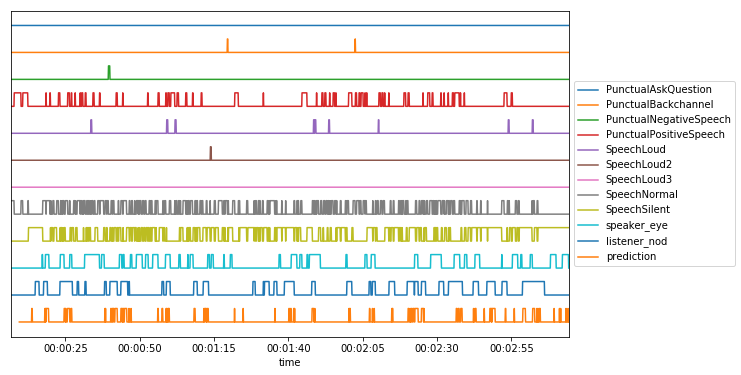

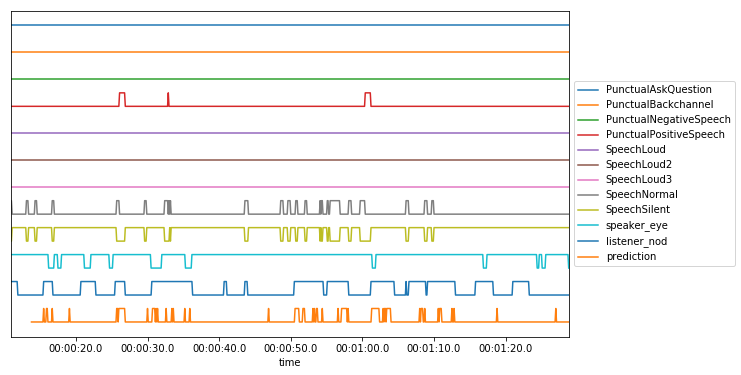

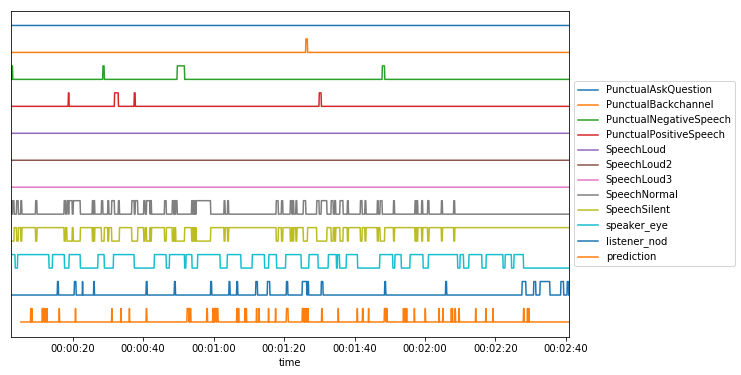

In [16]:
%%time

for key in random.sample(store.keys(), 3):
    print(key)
    df = prepare_for_training(store[key], speaker_behaviours)
    set_prediction(clf, df)
    plot_data(df)

In [17]:
%%time

Ypredict = clf.predict(Xtest)

CPU times: user 14min 40s, sys: 463 ms, total: 14min 41s
Wall time: 3min 47s


In [18]:
print(metrics.classification_report(Ytest, Ypredict))

             precision    recall  f1-score   support

      False       0.87      0.96      0.91     13107
       True       0.45      0.16      0.24      2356

avg / total       0.80      0.84      0.81     15463

